In [ ]:
!nvidia-smi

Tue Jan 26 22:57:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip

--2021-01-26 16:06:31--  https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
Resolving unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)... 52.216.128.155
Connecting to unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)|52.216.128.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385725291 (368M) [application/zip]
Saving to: ‘unsplash-research-dataset-lite-latest.zip’

unsplash-research-d 100%[===================>] 367.86M  36.2MB/s    in 11s     

2021-01-26 16:06:42 (34.1 MB/s) - ‘unsplash-research-dataset-lite-latest.zip’ saved [385725291/385725291]



In [ ]:
!unzip unsplash-research-dataset-lite-latest.zip

Archive:  unsplash-research-dataset-lite-latest.zip
  inflating: README.md               
  inflating: TERMS.md                
  inflating: collections.tsv000      
  inflating: colors.tsv000           
  inflating: conversions.tsv000      
  inflating: keywords.tsv000         
  inflating: photos.tsv000           


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp -r /content/drive/MyDrive/unsplash-dataset /content/

In [ ]:
!git clone https://github.com/openai/CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), done.


In [ ]:
!pip install ftfy

     |████████████████████████████████| 71kB 4.8MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=34905fff3ae15112c7f5fa7015fcc68879ff9e71ad4d055b9e88f605d2f46999
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy


In [ ]:
import sys

CLIP_DIR = "CLIP"
sys.path.append(CLIP_DIR)

In [ ]:
import clip

In [ ]:
import torch
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
import csv

In [10]:
photo_urls = []
with open("photos.tsv000") as fIn:
    reader = csv.DictReader(fIn, delimiter='\t')
    for row in tqdm(reader):
        photo_urls.append([row['photo_id'], row['photo_image_url']])

print(f'Photos in the dataset: {len(photo_urls)}')


Photos in the dataset: 25000


In [11]:
from pathlib import Path

dataset_version = "lite"
unsplash_dataset_path = Path("unsplash-dataset") / dataset_version

In [12]:
import urllib.request

photos_download_path = unsplash_dataset_path / "photos"

def download_photo(photo):
    photo_id = photo[0]
    # Get the URL of the photo (setting the width to 640 pixels)
    photo_url = photo[1] + "?w=640"
    photo_path = photos_download_path / (photo_id + ".jpg")
    if not photo_path.exists():
        try:
            urllib.request.urlretrieve(photo_url, photo_path)
        except Exception as e:
            print(f"Cannot download {photo_url}", e)
            pass

In [ ]:
photos_download_path.mkdir(parents=True)

In [13]:
from multiprocessing.pool import ThreadPool

# Create the thread pool
threads_count = 256
pool = ThreadPool(threads_count)

In [46]:
# Start the download
ret = pool.map(download_photo, photo_urls)

Cannot download https://images.unsplash.com/photo-1481930079977-24a345fcae85?w=640 HTTP Error 422: Unprocessable Entity
Cannot download https://images.unsplash.company%20by%20Alessandro%20Desantis%20-%20Downloaded%20from%20500px_jpg.jpg?w=640 URL can't contain control characters. 'images.unsplash.company by Alessandro Desantis - Downloaded from 500px_jpg.jpg' (found at least ' ')
Cannot download https://images.unsplash.com_TheBeach.jpg?w=640 <urlopen error [Errno -2] Name or service not known>
Cannot download https://images.unsplash.com-grass-sun.jpg?w=640 <urlopen error [Errno -2] Name or service not known>


In [66]:
photos_files = list(photos_download_path.glob("*.jpg"))
print(f'Photos downloaded: {len(photos_files)}')

Photos downloaded: 24996


In [64]:
!zip -r -q /content/unsplash-dataset.zip /content/unsplash-dataset/

In [65]:
!cp /content/unsplash-dataset.zip /content/drive/MyDrive/

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████| 353976522/353976522 [00:05<00:00, 64727697.01it/s]


In [17]:
photos_files[0], photo_urls[0]

(PosixPath('unsplash-dataset/lite/photos/wmQH1N9tHFU.jpg'),
 ['2Q8zDWkj0Yw',
  'https://images.unsplash.com/photo-1415201179613-bd037ff5eb29'])

In [18]:
id_url_dict = {}
def assign(x):
    id_url_dict[x[0]]=x[1]
ret = list(map(assign, photo_urls))

In [19]:
def process_batch(photo_batch):
    images = []
    batch_photo_ids = []
    for pf in photo_batch:
        images.append(preprocess(Image.open(pf)))
        batch_photo_ids.append(pf.name.split('.jpg')[0])
    images_tensor = torch.stack(images).to(device)
    with torch.no_grad():
        images_features = model.encode_image(images_tensor)
        images_features /= images_features.norm(dim=-1, keepdim=True)
    return images_features.cpu(), batch_photo_ids

In [ ]:
BATCH_SIZE = 256
images_embeddings = []
photo_ids = []

for i in tqdm(range(0, len(photos_files), BATCH_SIZE)):
    images_features, batch_photo_ids = process_batch(photos_files[i:i+BATCH_SIZE])
    photo_ids.extend(batch_photo_ids)
    images_embeddings.append(images_features)

In [ ]:
images_embeddings = torch.cat(images_embeddings)

In [ ]:
images_embeddings.shape, len(photo_ids)

(torch.Size([24996, 512]), 24996)

In [ ]:
# torch.save(images_embeddings, 'images_embeddings.pt')

In [20]:
images_embeddings = torch.load('images_embeddings.pt')

In [21]:
import pickle

In [ ]:
# with open('photo_ids.list', 'wb') as fp:
#     pickle.dump(photo_ids, fp)

In [22]:
with open('photo_ids.list', 'rb') as fp:
    photo_ids = pickle.load(fp)

In [23]:
images_embeddings.shape, len(photo_ids)

(torch.Size([24996, 512]), 24996)

In [24]:
images_embeddings = images_embeddings.to(device)

In [25]:
def get_sim(inp_q=["sun rising"]):
    with torch.no_grad():
        text = clip.tokenize(inp_q)
        text = text.to(device)
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logit_scale = 100#model.logit_scale.exp()
        logits_per_image = (logit_scale * images_embeddings @ text_features.t()).squeeze()
        logits_per_image = logits_per_image.cpu().numpy()
    return logits_per_image

In [26]:
text = clip.tokenize(["sun rising"]).to(device)

In [60]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [61]:
with torch.no_grad():
    text_features = model.encode_text(text)

In [62]:
text_features[0,:20]

tensor([-0.1146, -0.0977, -0.1477,  0.0672, -0.0723,  0.0404, -0.1159, -1.4199,
        -0.0329,  0.3940, -0.0030, -0.0785, -0.2241, -0.4226, -0.2502,  0.0893,
        -0.0255,  0.3706, -0.0875,  0.2710], device='cuda:0',
       dtype=torch.float16)

In [57]:
text_features[0,:20]

tensor([ 0.1234, -0.1059,  0.2957, -0.0761,  0.9922, -0.0580, -0.1415,  0.3259,
        -0.3242,  0.5117,  0.0408, -0.3127,  0.1125,  0.0170,  0.0014,  0.3130,
        -0.0281,  0.0524, -0.3916,  0.3857], device='cuda:0',
       dtype=torch.float16)

In [50]:
logits_per_image = get_sim(["sun rising"])
logits_per_image[:20]

array([21.23, 18.  , 20.28, 19.89, 24.39, 17.75, 24.34, 17.67, 21.27,
       21.23, 18.  , 21.27, 22.12, 20.92, 20.73, 20.81, 18.2 , 24.9 ,
       18.9 , 21.02], dtype=float16)

In [51]:
logits_per_image[:20]

array([21.23, 18.  , 20.28, 19.89, 24.39, 17.75, 24.34, 17.67, 21.27,
       21.23, 18.  , 21.27, 22.12, 20.92, 20.73, 20.81, 18.2 , 24.9 ,
       18.9 , 21.02], dtype=float16)

In [52]:
best_photo_idx = np.argsort(logits_per_image)[::-1]
best_photos = [(logits_per_image[i],i) for i in best_photo_idx]
best_photos[:5]

[(26.86, 24886), (26.77, 183), (26.72, 53), (26.52, 159), (26.14, 231)]

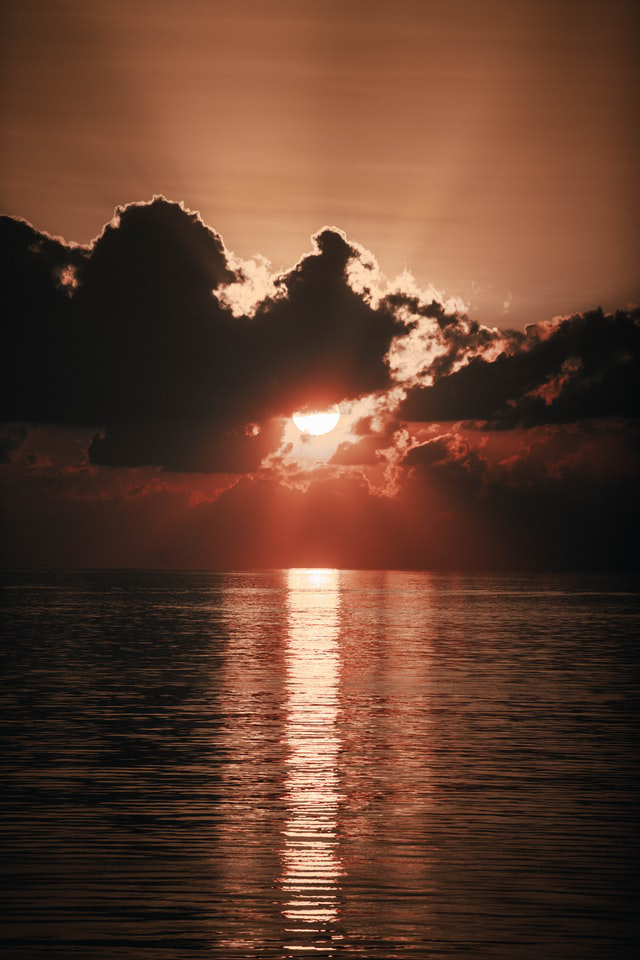

In [53]:
Image.open(photos_download_path / (photo_ids[best_photo_idx[0]] + ".jpg"))